In [8]:
import scanpy as sc
import numpy as np
import urllib.request
import anndata
import pandas as pd
from pathlib import Path
from scipy.sparse import issparse
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
font_dirs = ['/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

mpl.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']  
plt.rcParams['pdf.fonttype'] = 42

sns.set_style('white')

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [9]:
df = pd.read_table('result/psi/dataset1/psi.tab.gz',index_col=0).T
df = df.map(lambda x: np.random.uniform(0, 1) if pd.isna(x) else x)

In [10]:
adata = sc.AnnData(df)

In [12]:
# Read the cell type mapping table and convert it to a dictionary with cell_id as keys and cell_type as values
cell_type_dict = pd.read_table('dataset1/srr_2_cell_type.txt', header=0)
cell_type_dict = cell_type_dict.set_index('cell_id')['cell_type'].to_dict()

# Filter cell IDs in adata that exist in the cell_type_dict keys
cell_ids = [cell_id for cell_id in adata.obs_names if cell_id in cell_type_dict.keys()]

# Subset adata to keep only the filtered cells and create a copy
adata = adata[cell_ids, :].copy()

# Add cell type annotation to adata.obs
adata.obs['cell_type'] = [cell_type_dict[idx] for idx in adata.obs_names]

# Duplicate the 'cell_type' column as 'cell.type' for convenience
adata.obs['cell.type'] = adata.obs['cell_type']

# Replace adata's expression matrix X with the Psi layer (percent spliced-in values)
adata.X = adata.layers['Psi']

In [13]:
def get_predicted_type(adata):
    obs = adata.obs
    type_dict = {}
    for leiden in adata.obs.leiden.cat.categories:
        sub_obs =obs[obs['leiden'] == leiden]
        major_cell_type = sub_obs['cell.type'].value_counts().idxmax()
        type_dict[leiden] = major_cell_type
    adata.obs['AS_cell_type'] = adata.obs['leiden'].astype(str)
    adata.obs['AS_cell_type'] = adata.obs['AS_cell_type'].replace(type_dict)
    return adata
    
def get_accuracy(adata):
    adata = get_predicted_type(adata)
    accuracy = accuracy_score(adata.obs['cell.type'], adata.obs['AS_cell_type'])
    return accuracy

In [14]:
tool = 'Psix'
results = []

import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score


for n_genes in [2000,5000,'all']:
    if n_genes == 'all':
        ...
    else:
        sc.pp.highly_variable_genes(adata,min_mean=0.0, max_mean=10, min_disp=0.5,n_top_genes=n_genes)

    if n_genes == 'all':
        sc.tl.pca(adata, mask_var=None)
    else:
        sc.tl.pca(adata, mask_var="highly_variable")

    for nei in [10, 15, 20, 30, 40]:
        for pc in [5, 7, 9, 10, 15, 20]:
            sc.pp.neighbors(adata, n_neighbors=nei, n_pcs=pc)
            sc.tl.umap(adata)
            for res in [0.6, 0.7, 0.8, 0.9, 1, 1.1]:
                sc.tl.leiden(adata, resolution=res, random_state=0, n_iterations=10, directed=False)
                
                accuracy = get_accuracy(adata)
                true_labels = adata.obs["cell.type"]
                predicted_labels = adata.obs["AS_cell_type"]
                ari = adjusted_rand_score(true_labels, predicted_labels)
                nmi = normalized_mutual_info_score(true_labels, predicted_labels)
                umap_embedding = adata.obsm["X_umap"]
                silhouette = silhouette_score(umap_embedding, predicted_labels)
                
                # 计算 BCI（四个指标的均值）
                bci = (accuracy + ari + nmi + silhouette) / 4
                
                results.append({
                    'n_top_genes': n_genes,
                    'n_neighbors': nei,
                    'n_pcs': pc,
                    'resolution': res,
                    'accuracy': accuracy,
                    'ARI': ari,
                    'NMI': nmi,
                    'Silhouette': silhouette,
                    'BCI': bci
                })

accuracy_df = pd.DataFrame(results).sort_values(by='BCI', ascending=False)
accuracy_df.to_csv('BCI_{}_.txt'.format(tool),sep='\t')
print(accuracy_df)

/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
2025-07-09 15:25:33.863543: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 15:25:33.866109: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 15:25:33.898477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-09 15:25:34.491283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/tmp/ipykernel_127742/1523801264.py:26: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, random_state=0, n_iterations=10, directed=False)
/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


    n_top_genes  n_neighbors  n_pcs  resolution  accuracy       ARI       NMI  \
385         all           10     15         0.7  0.932253  0.880130  0.903380   
386         all           10     15         0.8  0.932253  0.880130  0.903380   
387         all           10     15         0.9  0.932253  0.880130  0.903380   
388         all           10     15         1.0  0.932253  0.880130  0.903380   
393         all           10     20         0.9  0.932253  0.879246  0.901781   
..          ...          ...    ...         ...       ...       ...       ...   
138        2000           30     20         0.6  0.661267  0.615643  0.749938   
139        2000           30     20         0.7  0.661267  0.615643  0.749938   
102        2000           20     20         0.6  0.661267  0.615643  0.749938   
66         2000           15     20         0.6  0.659794  0.608906  0.742033   
30         2000           10     20         0.6  0.659794  0.612039  0.750746   

     Silhouette       BCI  

In [13]:
n_genes,n_neighbors,n_pcs,resolution ,accuracy = accuracy_df.iloc[0]
if n_genes == 'all':
        ...
else:
    sc.pp.highly_variable_genes(adata,min_mean=0.0, max_mean=10, min_disp=0.5,n_top_genes=n_genes)
    
if n_genes == 'all':
    sc.tl.pca(adata, mask_var=None)
else:
    sc.tl.pca(adata, mask_var="highly_variable")
sc.pp.neighbors(adata, n_neighbors=int(n_neighbors), n_pcs=int(n_pcs))
sc.tl.umap(adata,)
sc.tl.leiden( adata, resolution=resolution, random_state=0,n_iterations=10, directed=False,) #聚类跟umap或是tsne都没关系
adata = get_predicted_type(adata)

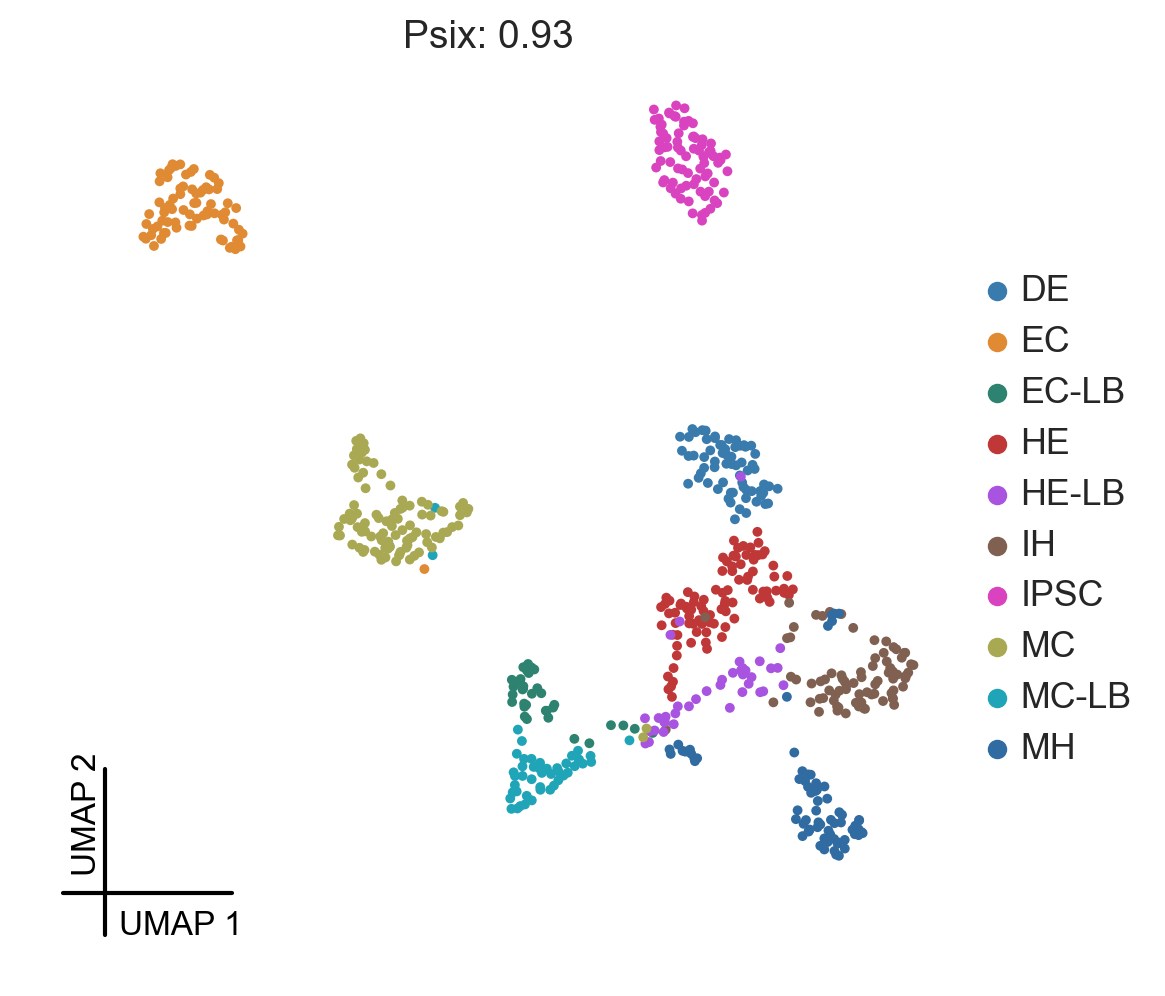

In [14]:
tool = 'Psix'
sc.settings.set_figure_params(
    dpi=100,               # 图像分辨率
    facecolor='white'      # 背景颜色
)

custom_palette = ['#3a7bae', '#e08b33', '#2d8270', '#c03737', '#a854e1', '#806051',
                  '#d943bf', '#a9a853', '#1fa5b7', '#306ba1', '#ff9c33', '#3daf84',
                  '#de4848', '#b553f0']

title = '{}: {:.2}'.format(tool,accuracy)
fo = "umap_accuracy.{}.pdf".format(tool)

fig, ax = plt.subplots(figsize=(6, 6))
# 绘制 UMAP 图
sc.pl.umap(
    adata,
    color="cell.type",  # 替换为你的分类变量
    palette=custom_palette,
    ax=ax,
    show=False,
    frameon=False, # 关闭默认边框
    s = 50,title=title)

# 获取当前轴范围
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 参数设置
border_length = 0.15  # 边框长度比例
arrow_size = 0.03    # 箭头长度比例
line_width = 1.5     # 线条粗细

# 绘制短边框和箭头
left_border_extension = 0.05  # 左边框向下延伸的比例
bottom_border_extension = 0.05  # 下边框向左延伸的比例

# 绘制短边框和箭头
ax.plot([xlim[0], xlim[0]], [ylim[0] - left_border_extension * (ylim[1] - ylim[0]), ylim[0] + border_length * (ylim[1] - ylim[0])],
        color="black", lw=line_width, zorder=5)  # 左边框
ax.plot([xlim[0] - bottom_border_extension * (xlim[1] - xlim[0]), xlim[0] + border_length * (xlim[1] - xlim[0])], [ylim[0], ylim[0]],
        color="black", lw=line_width, zorder=5)  # 下边框


# 自动计算标签位置的代码
x_offset_umap1 = border_length * (xlim[1] - xlim[0]) - 0.06 * (xlim[1] - xlim[0])  # 动态计算 UMAP 1 的水平偏移
y_offset_umap1 = -0.05 * (ylim[1] - ylim[0])                                       # 动态计算 UMAP 1 的垂直偏移

x_offset_umap2 = -0.02 * (xlim[1] - xlim[0])                                       # 动态计算 UMAP 2 的水平偏移
y_offset_umap2 = border_length * (ylim[1] - ylim[0]) - 0.12 * (ylim[1] - ylim[0])  # 动态计算 UMAP 2 的垂直偏移

# 添加 UMAP 1 标签
ax.text(xlim[0] + x_offset_umap1,
        ylim[0] + y_offset_umap1,
        "UMAP 1", fontsize=12, color='black', ha='center')

# 添加 UMAP 2 标签
ax.text(xlim[0] + x_offset_umap2,
        ylim[0] + y_offset_umap2,
        "UMAP 2", fontsize=12, color='black', ha='center', rotation=90)

# 隐藏刻度线和刻度标签
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
fig.savefig(fo, dpi=300, bbox_inches="tight") 
plt.show()

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

import scib

# 获取数据
umap_embedding = adata.obsm["X_umap"]  # 获取 UMAP 坐标
true_labels = adata.obs["cell.type"]  # 如果有真实标签
predicted_labels = adata.obs["AS_cell_type"]  # 聚类结果
cluster_labels = adata.obs['leiden']
adata.obs['batch'] = ['batch1'] * adata.shape[0]

def compute_cASW(umap_embedding, true_labels):
    # 计算每个细胞的轮廓宽度
    silhouette_values = silhouette_samples(umap_embedding, true_labels)

    # 计算每个细胞类型的平均轮廓宽度
    silhouette_df = pd.DataFrame({'cell_type': true_labels, 'silhouette_value': silhouette_values})
    average_silhouette_per_type = silhouette_df.groupby('cell_type', observed=True)['silhouette_value'].mean()
    mean_asw = average_silhouette_per_type.mean()
    return mean_asw

def compute_cLISI_custom(adata, label_key="cell.type", embedding_key="X_umap", k=30, max_val=5.0):
    X = adata.obsm[embedding_key]
    labels = adata.obs[label_key].values
    n_cells = X.shape[0]
    
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)  # +1 因为包括自己
    neighbors = nn.kneighbors(X, return_distance=False)[:, 1:]  # 去掉自身

    # Simpson Index for each cell
    lisi_values = []
    for i in range(n_cells):
        neighbor_labels = labels[neighbors[i]]
        freqs = pd.Series(neighbor_labels).value_counts(normalize=True)
        simpson = (freqs**2).sum()  # Simpson Index
        lisi = 1.0 / simpson  # LISI = 1 / Simpson
        lisi_values.append(lisi)

    lisi_values = np.array(lisi_values)
    cLISI_raw = np.mean(lisi_values)
    cLISI_transformed = 1 - np.clip(cLISI_raw / max_val, 0, 1)
    return cLISI_transformed

# 计算准确率（如果标签是分类标签）
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# 计算 ARI
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# 计算 NMI
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")

# 计算轮廓系数
silhouette = silhouette_score(umap_embedding, predicted_labels)
print(f"Silhouette Score: {silhouette}")

# 计算不同标签的 ASW
cellASW = compute_cASW(umap_embedding, true_labels)
print(f"cellASW: {cellASW}")  # average silhouette width based on cell type

predictASW = compute_cASW(umap_embedding, predicted_labels)
print(f"predictASW: {predictASW}")  # average silhouette width based on predicted type

clusterASW = compute_cASW(umap_embedding, cluster_labels)
print(f"clusterASW: {clusterASW}")  # average silhouette width based on cluster

# 计算 Davies-Bouldin 和 Calinski-Harabasz 得分
db_score = davies_bouldin_score(umap_embedding, predicted_labels)
print(f"Davies-Bouldin Score: {db_score}")

ch_score = calinski_harabasz_score(umap_embedding, predicted_labels)
print(f"Calinski-Harabasz Score: {ch_score}")

cLISI = compute_cLISI_custom(adata,label_key="cell.type",embedding_key="X_umap",)
print(f"cLISI Score: {cLISI}")

# 保存结果到文件
output_file = 'Evaluation_score.txt'
with open(output_file, 'w') as o:
    o.write('Metric\tScore\n')  # 写入表头
    o.write('Accuracy\t' + str(accuracy) + '\n')
    o.write('Adjusted Rand Index (ARI)\t' + str(ari) + '\n')
    o.write('Normalized Mutual Information (NMI)\t' + str(nmi) + '\n')
    o.write('Silhouette Score\t' + str(silhouette) + '\n')
    o.write('Cell Type ASW\t' + str(cellASW) + '\n')
    o.write('Predicted Type ASW\t' + str(predictASW) + '\n')
    o.write('Cluster ASW\t' + str(clusterASW) + '\n')
    o.write('Davies-Bouldin Score\t' + str(db_score) + '\n')
    o.write('Calinski-Harabasz Score\t' + str(ch_score) + '\n')
    o.write('cLISI Score\t' + str(cLISI) + '\n')


Accuracy: 0.9322533136966127
Adjusted Rand Index (ARI): 0.8782350140889834
Normalized Mutual Information (NMI): 0.8919133328822161
Silhouette Score: 0.6670613288879395
cellASW: 0.5480755567550659
predictASW: 0.6630449891090393
clusterASW: 0.6256861090660095
Davies-Bouldin Score: 0.4779799273460729
Calinski-Harabasz Score: 3982.447946531922
cLISI Score: 0.7491766423424808


/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
